In [1]:
import pandas as pd
from Bio import AlignIO
import os
import matplotlib.pyplot as plt
import pyranges as pr

In [2]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower()

In [3]:
#path = '../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/'

In [4]:
#align = AlignIO.read(open('../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/P00519_clustalO_fullidentity_all.fasta.aln'), format= 'fasta')
#len(align) # hacer una distribucion

# Distribution seqs/MSA

In [5]:
def seqs_per_msa(path):
    '''
    returns a DataFrame with number of sequences in each MSA
    path: path to folder containing MSA files
    '''
    # iterate over the MSA files
    seqs_msa = {}
    l = []
    no_errors = 0
    i = 0
    for filename in os.listdir(path):
        f = os.path.join(path, filename) # is the complete path to each msa

        if os.path.isfile(f):
            
            # Check if file is empty
            check_file = os.stat(f).st_size
            if check_file != 0:
                msa_name = filename.split(".")[0].split("_")
                msa_name = msa_name[0] + "_" + msa_name[3]
                # align objects can be treated as lists of SeqRecord objects
                align = AlignIO.read(open(f), format= 'fasta')
                for record in align:
                    try:
                        l.append([msa_name, record.id, len(record)])
                        #print("%s %i" % (record.id, len(record)))
                        seqs_msa[msa_name] = len(align)
                        # to dataframe
                        
                        i += 1
                    except:
                        print(f"error in file {filename}")
                        no_errors += 1
    df = pd.DataFrame.from_dict(seqs_msa, orient= 'index').reset_index().rename(columns= {'index': 'msa', 0: 'no_seqs'})
    return df, l

In [6]:
# df no. of seqs per MSA
seqs_msa, l = seqs_per_msa(path= '../homology_transfer/pipeline_MSA_uniprot/data_snake/09_align_selection/')
seqs_msa

,msa,no_seqs
0,O49717_all,6
1,P08414_80,15
2,Q8C078_60,94
3,Q8BRK8_80,109
4,P04049_60,72
...,...,...
745,Q9SG12_80,4
746,Q13164_60,62
747,P21802_60,68
748,Q9NJU9_80,2


<AxesSubplot:>

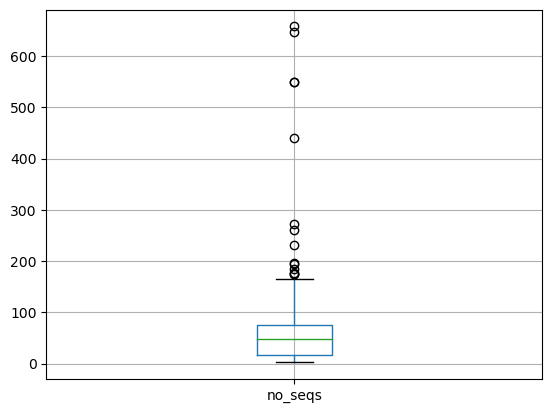

In [7]:
seqs_msa.boxplot()

In [8]:
def plot_distrib_msa(data, threshold= 'all'):
    threshold = str(threshold)
    data[data.msa.str.endswith(threshold)].no_seqs.plot(kind= 'hist', bins= 50, color= 'gray', edgecolor= 'black')
    plt.title(f"Distribution #seqs/MSA\nthreshold = {threshold}")
    plt.ylabel("# MSAs")
    plt.xlabel('# sequences')
    plt.show()

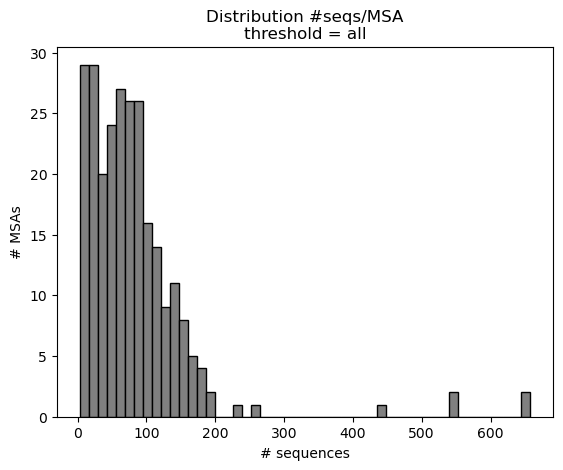

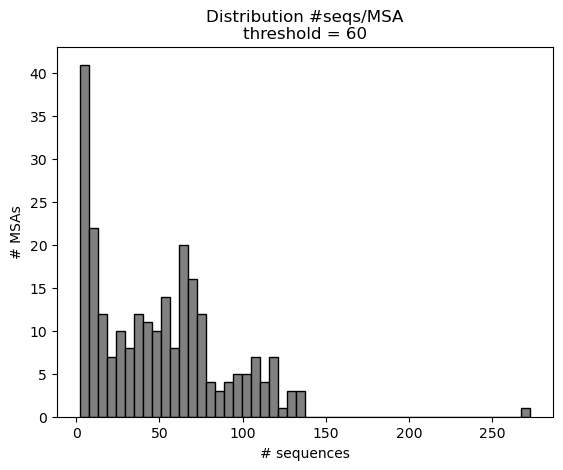

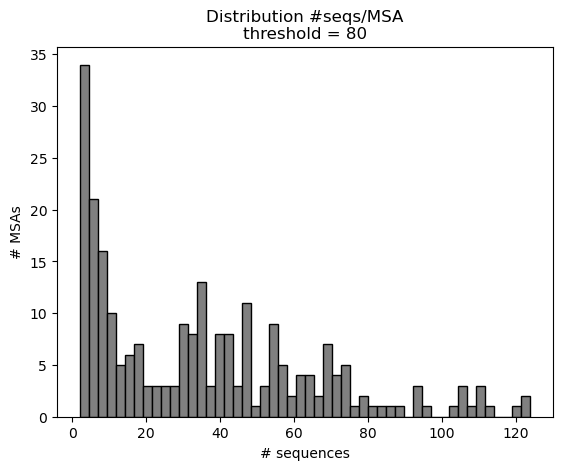

In [9]:
plot_distrib_msa(data= seqs_msa)
plot_distrib_msa(data= seqs_msa, threshold=60)
plot_distrib_msa(data= seqs_msa, threshold=80)

In [10]:
len(seqs_msa[(seqs_msa.msa.str.endswith("all")) & (seqs_msa.no_seqs >= 100)])

70

In [11]:
len(seqs_msa[(seqs_msa.msa.str.endswith("60")) & (seqs_msa.no_seqs >= 100)])

31

In [12]:
len(seqs_msa[(seqs_msa.msa.str.endswith("80")) & (seqs_msa.no_seqs >= 100)])

12

# Orthologs overlap

In [13]:
all_msas = pd.DataFrame(l, columns= ['msa', 'uniprot', 'length_msa'])
all_msas

,msa,uniprot,length_msa
0,O49717_all,O49717,597
1,O49717_all,A0A0D3A511,597
2,O49717_all,A0A364KUL0,597
3,O49717_all,D7MEB5,597
4,O49717_all,M4DAR5,597
...,...,...,...
42178,Q9NJU9_80,A0A0L7M6Y1,563
42179,Q9FMP5_80,Q9FMP5,586
42180,Q9FMP5_80,A0A087G6J2,586
42181,Q9FMP5_80,M4E3L4,586


In [104]:
#all_msas.to_csv('../datasets/all_msas.tsv', sep= '\t', index= False)

In [14]:
# Subset the MSAs
all = all_msas[all_msas.msa.str.endswith("all")]
msa_60 = all_msas[all_msas.msa.str.endswith("60")]
msa_80 = all_msas[all_msas.msa.str.endswith("80")]

In [15]:
# list with kinases reference proteins
kin = kinases.uniprot.unique().tolist()

In [16]:
# Create sets with unique proteins in each msa
all = all.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
all

,msa,uniprot
0,A0A2I0BVG8_all,"[A0A2I0BVG8, A0A023B173, A0A0C2IKB7, A0A0D9QJY..."
1,A0A509AFG4_all,"[A0A509AFG4, A0A015KQ67, A0A059J0T9, A0A0D9QSD..."
2,A0A509AHB6_all,"[A0A509AHB6, A0A023B173, A0A0C2IKB7, A0A0D2VHA..."
3,A0A509AKL0_all,"[A0A509AKL0, A0A023B252, A0A061DD08, A0A068Y9V..."
4,A0A509AQE6_all,"[A0A509AQE6, A0A015K587, A0A023BCV0, A0A061DD0..."
...,...,...
252,Q9ZSA3_all,"[Q9ZSA3, A0A087GM80, B6EP77, G8JN52, K5BI95, M..."
253,Q9ZSA4_all,"[Q9ZSA4, A0A0L8ICP1, A0A668RKR5, A3DEI9, C4Y9R..."
254,Q9ZUZ2_all,"[Q9ZUZ2, A0A059C0N6, A0A061CZ84, A0A061DU80, A..."
255,Q9ZV15_all,"[Q9ZV15, A0A059DJ09, A0A068UQL6, A0A087H3U3, A..."


In [17]:
def find_overlaps(df, refers):
    '''
    df: dataframe containing MSAs and list of proteins in each one
    refers: list containing reference proteins for checking overlap
    returns dataframe with MSA name, list of proteins in that MSA and list of reference
    proteins in that MSA
    '''
    # Create lists with proteins in each msa
    df = df.groupby("msa").agg({'uniprot': lambda x: x.tolist()}).reset_index()
    df["overlap"] = [ [] for _ in range(len(df))]
    for ix in df.index:
        lst = df.uniprot[ix][1:] # exclude the first because is the reference
        for kinase in refers:
            if kinase in lst:
                df["overlap"][ix].append(kinase)
    return df

In [18]:
# Ok. tested
def plot_overlap(msa, refers, title, color= 'royalblue', bins= 6):
    '''
    plot overlaping reference proteins in MSAs 
    '''
    df = find_overlaps(msa, refers)
    df.overlap.apply(lambda x: len(x)).plot(
    kind= 'hist',
    color= color,
    edgecolor= 'black',
    bins= bins
    )
    plt.title(title)
    plt.xlabel("# proteins")
    plt.show()


### Plots overlap

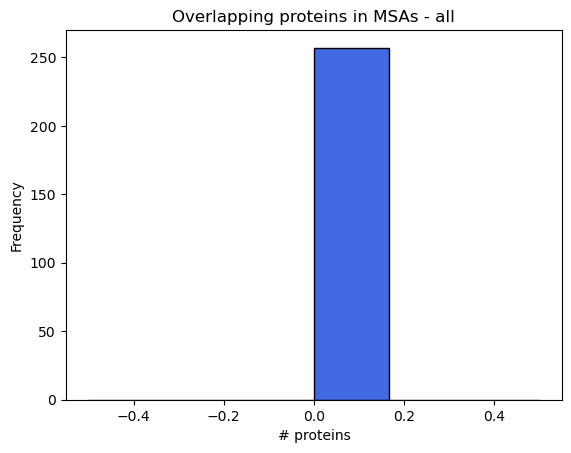

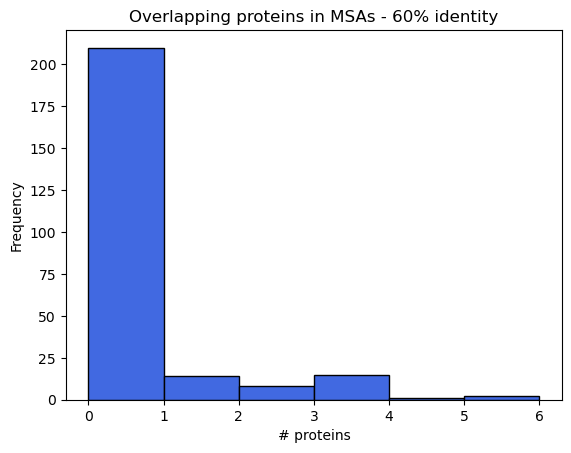

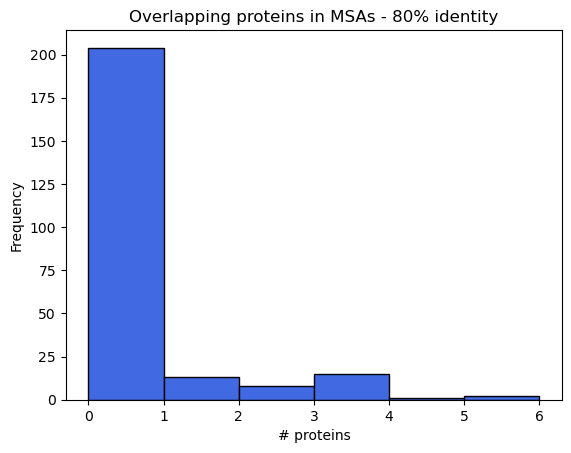

In [19]:
plot_overlap(all, refers= kin, title= "Overlapping proteins in MSAs - all")
plot_overlap(msa_60, refers= kin, title= "Overlapping proteins in MSAs - 60% identity")
plot_overlap(msa_80, refers= kin, title= "Overlapping proteins in MSAs - 80% identity")

---

# Mapping PDBs to orthologs 

In [20]:
sift = pd.read_csv(
    '../datasets/uniprot_segments_observed.tsv.gz',
    sep= '\t',
    compression= 'gzip',
    skiprows= 1
)
sift.columns = sift.columns.str.lower()

In [21]:
sift

,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
0,121p,A,P01112,1,166,1,166,1,166
1,132l,A,P00698,1,129,1,129,19,147
2,133l,A,P61626,1,130,1,130,19,148
3,129l,A,P00720,1,162,1,162,1,162
4,139l,A,P00720,1,162,1,162,1,162
...,...,...,...,...,...,...,...,...,...
977668,6e9d,v,P03135,226,735,226,735,226,735
977669,6e9d,w,P03135,226,735,226,735,226,735
977670,6e9d,x,P03135,226,735,226,735,226,735
977671,6e9d,y,P03135,226,735,226,735,226,735


In [122]:
pdb_uniprot_map = sift[['pdb', 'sp_primary']].drop_duplicates().rename(columns= 
    {
    'sp_primary': 'uniprot',
    'sp_beg': 'start',
    'sp_end': 'end'    
    }
)
pdb_uniprot_map

,pdb,uniprot
0,121p,P01112
1,132l,P00698
2,133l,P61626
3,129l,P00720
4,139l,P00720
...,...,...
977587,6eae,P03420
977589,6e9p,P9WFY1
977591,6e9p,P9WFX9
977601,6eaf,P03420


In [23]:
# Mapping: pdbs for each uniprot
pdb_uniprot = sift[['pdb', 'sp_primary', 'chain', 'sp_beg', 'sp_end']].drop_duplicates().rename(columns= 
    {
    'sp_primary': 'uniprot_acc',
    'sp_beg': 'start',
    'sp_end': 'end'    
    }
)
pdb_uniprot

,pdb,uniprot_acc,chain,start,end
0,121p,P01112,A,1,166
1,132l,P00698,A,19,147
2,133l,P61626,A,19,148
3,129l,P00720,A,1,162
4,139l,P00720,A,1,162
...,...,...,...,...,...
977668,6e9d,P03135,v,226,735
977669,6e9d,P03135,w,226,735
977670,6e9d,P03135,x,226,735
977671,6e9d,P03135,y,226,735


In [24]:
# Get list of orthologs
ortho = all_msas.uniprot.unique().tolist()

In [25]:
len(ortho)

13652

In [26]:
# Save it
# with open('../datasets/all_orthologs.txt', 'w') as f:
#     for protein in ortho:
#         f.write(f"{protein}\n")

### How many orthologs proteins have pdb structure

In [27]:
# How many orthologs proteins have pdb structure
pdb_orthologs = pdb_uniprot[pdb_uniprot.uniprot_acc.isin(ortho)]
pdb_orthologs

,pdb,uniprot_acc,chain,start,end
965,1gag,P06213,A,1008,1310
1044,1gzo,P31751,A,146,188
1045,1gzo,P31751,A,198,296
1046,1gzo,P31751,A,313,442
1234,1i35,P28829,A,71,165
...,...,...,...,...,...
977457,7up8,O75582,B,559,574
977458,7up8,O75582,B,600,624
977459,7up8,O75582,B,630,727
977487,7pi4,Q05397,DDD,415,573


In [28]:
f"{pdb_orthologs.uniprot_acc.nunique()} out of {len(ortho)} ortholog proteins have {pdb_orthologs.pdb.nunique()} PDB structure"

'126 out of 13652 ortholog proteins have 2157 PDB structure'

In [105]:
# estas 2157 estructuras corresponden a todas las secuencias ortologas, 
# es decir, estan distribuidas en todos los MSAs

In [29]:
# Check with uniprotKB advance search
ortho_uniprot = pd.read_csv('../raw_data/orthologs-uniprot-structure-2022.11.18-20.00.24.25.tsv.gz', sep= '\t', compression= 'gzip')
ortho_uniprot.info() # 127 proteins with 3D structures, ok! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13652 entries, 0 to 13651
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   From        13652 non-null  object
 1   Entry       13652 non-null  object
 2   Entry Name  13652 non-null  object
 3   Length      13652 non-null  int64 
 4   3D          127 non-null    object
dtypes: int64(1), object(4)
memory usage: 533.4+ KB


In [30]:
# Buscar de esta lista de 126 proteinas, cuales son de referencia en MSAs
all["reference"] = all.msa.apply(lambda x: x.split("_")[0])

In [31]:
all[all.reference.isin(pdb_orthologs.uniprot_acc)]

,msa,uniprot,reference
9,A5K0N4_all,"[A5K0N4, A0A023B252, A0A061DD08, A0A090LL98, A...",A5K0N4
14,O14757_all,"[O14757, A0A010QQY9, A0A017SJY9, A0A026WMA8, A...",O14757
17,O43318_all,"[O43318, A0A015KBU3, A0A023BBL1, A0A026W016, A...",O43318
19,O74536_all,"[O74536, A0A010REC8, A0A015NFB9, A0A023B5H0, A...",O74536
20,O75582_all,"[O75582, A0A060W937, A0A087YI90, A0A091CKQ0, A...",O75582
...,...,...,...
230,Q9H4A3_all,"[Q9H4A3, A0A084QN01, A0A087XNA6, A0A0D9RGY6, A...",Q9H4A3
231,Q9JIH7_all,"[Q9JIH7, A0A058ZEP2, A0A087XNA6, A0A0N1I038, A...",Q9JIH7
236,Q9NJU9_all,"[Q9NJU9, A0A0D9QSD5, A0A0L7M6Y1, A0A1A8B2I9, A...",Q9NJU9
246,Q9UIK4_all,"[Q9UIK4, A0A067CHY9, A0A096LS66, A0A0B2V584, A...",Q9UIK4


In [111]:
# Buscar de esta lista de 126 proteinas, cuales son de referencia en MSAs
msa_60["reference"] = msa_60.msa.apply(lambda x: x.split("_")[0])
msa_60[msa_60.reference.isin(pdb_orthologs.uniprot_acc)]

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,msa,uniprot,length_msa,reference
224,P04049_60,P04049,842,P04049
225,P04049_60,A0A096NYS4,842,P04049
226,P04049_60,A0A0D9RB89,842,P04049
227,P04049_60,A0A286XGN9,842,P04049
228,P04049_60,A0A2D0PJA7,842,P04049
...,...,...,...,...
42172,P21802_60,H3D7B8,887,P21802
42173,P21802_60,K7FL51,887,P21802
42174,P21802_60,M3XV59,887,P21802
42175,P21802_60,U3JHI1,887,P21802


In [119]:
msa_60

,msa,uniprot,length_msa,reference
21,Q8C078_60,Q8C078,843,Q8C078
22,Q8C078_60,A0A091CXU0,843,Q8C078
23,Q8C078_60,A0A096N7S7,843,Q8C078
24,Q8C078_60,A0A0D9S4N6,843,Q8C078
25,Q8C078_60,A0A0Q3MME1,843,Q8C078
...,...,...,...,...
42172,P21802_60,H3D7B8,887,P21802
42173,P21802_60,K7FL51,887,P21802
42174,P21802_60,M3XV59,887,P21802
42175,P21802_60,U3JHI1,887,P21802


In [121]:
pdb_uniprot_map

,pdb,uniprot_acc
0,121p,P01112
1,132l,P00698
2,133l,P61626
3,129l,P00720
4,139l,P00720
...,...,...
977587,6eae,P03420
977589,6e9p,P9WFY1
977591,6e9p,P9WFX9
977601,6eaf,P03420


In [128]:
# Mapear los pdb a los msa al 60%
msa_60_pdb = msa_60.merge(pdb_uniprot_map)#.msa.nunique()#.pdb.nunique()
msa_60_pdb

,msa,uniprot,length_msa,reference,pdb
0,Q8C078_60,Q96RR4,843,Q8C078,5yv8
1,Q8C078_60,Q96RR4,843,Q8C078,5yvb
2,Q8C078_60,Q96RR4,843,Q8C078,6ble
3,Q8C078_60,Q96RR4,843,Q8C078,6y8a
4,Q8C078_60,Q96RR4,843,Q8C078,5yvc
...,...,...,...,...,...
2817,P21802_60,P21802,887,P21802,4j99
2818,P21802_60,P21802,887,P21802,1wvz
2819,P21802_60,P21802,887,P21802,3euu
2820,P21802_60,P21802,887,P21802,5eg3


In [141]:
msa_60_pdb_count = msa_60_pdb.groupby("msa")[['pdb']].count().reset_index().sort_values('pdb')

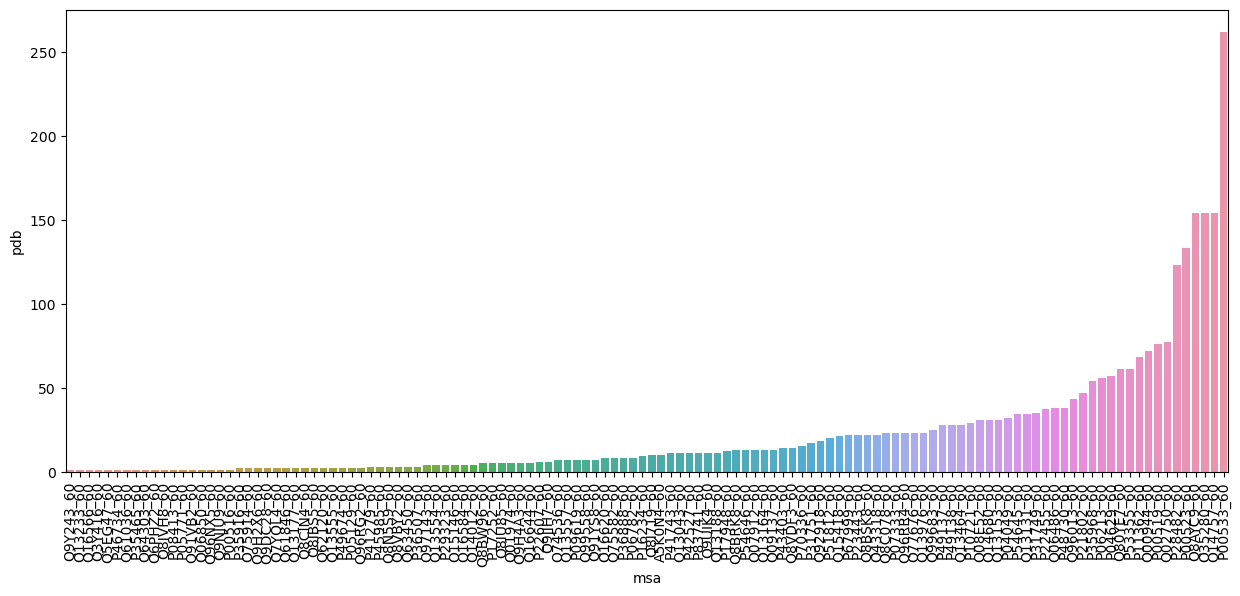

In [146]:
plt.figure(figsize= (15,6))
sns.barplot(data= msa_60_pdb_count, x= 'msa', y= 'pdb')
plt.xticks(rotation= 90)
plt.show()

---

### df with regions (KDs and CREs)  
for calculate regions MSAs using homology transfer pipeline

In [32]:
kinases = pd.read_csv('../datasets/kinases.tsv', sep= '\t')
kinases.columns = kinases.columns.str.lower().str.replace(" ", "_")
kinases = kinases.rename(columns= {'uniprot': 'uniprot_acc', 'cre_(start)': 'cre_start', 'cre_(end)': 'cre_end', 'kd_(start)': 'kd_start', 'kd_(end)': 'kd_end'})
kinases

,uniprot_acc,organism,cre_start,cre_end,cre_(s_or_d),length,kd_start,kd_end,pdb_id,pdb_res_(å),af,status
0,A0A2I0BVG8,P. falciparum (isolate NF54),346,353,no,NaN,56,325,no,no,AF-A0A2I0BVG8-F1,new
1,A0A509AFG4,P. berghei (strain Anka),385,393,no,NaN,110,365,no,no,AF-A0A509AFG4-F1,new
2,A0A509AHB6,P. berghei (strain Anka),345,352,no,NaN,57,324,no,no,AF-A0A509AHB6-F1,new
3,A0A509AKL0,P. berghei (strain Anka),1,33,no,NaN,545,802,no,no,AF-A0A509AKL0-F1,new
4,A0A509AQE6,P. berghei (strain Anka),394,402,no,NaN,118,372,no,no,AF-A0A509AQE6-F1,new
...,...,...,...,...,...,...,...,...,...,...,...,...
297,Q9ZSA4,A. thaliana,295,325,no,NaN,28,290,no,no,AF-Q9ZSA4-F1,new
298,Q9ZUZ2,A. thaliana,409,439,no,NaN,143,405,no,no,AF-Q9ZUZ2-F1,new
299,Q9ZV15,A. thaliana,398,428,no,NaN,134,392,no,no,AF-Q9ZV15-F1,new
300,W0LYS5,M. nipponense,287,327,no,NaN,31,287,no,no,AF-W0LYS5-F1,new


In [33]:
kd = kinases[['uniprot_acc', 'kd_start', 'kd_end']].drop_duplicates().rename(
    columns= {
        'kd_start': 'start',
        'kd_end': 'end'
    }
)
ids = [ "kd" + str(i) for i in range(1, len(kd)+1) ]
kd['term_id'] = ids
cre = kinases[['uniprot_acc', 'cre_start', 'cre_end']].drop_duplicates().rename(
    columns= {
        'cre_start': 'start',
        'cre_end': 'end'
    }
)
ids = [ "cre" + str(i) for i in range(1, len(cre)+1) ]
cre['term_id'] = ids

In [34]:
regions = pd.concat([kd, cre], ignore_index= True)

In [35]:
#kd.to_csv('../datasets/kd.tsv', sep= '\t', index= False)
#cre.to_csv('../datasets/cre.tsv', sep= '\t', index= False)
#regions.to_csv('../datasets/regions.txt', sep= '\t', index= False)

---

## mapear los PDB con las coord de KD y CRE

In [36]:
# Create PyRanges objects for joining them
# this is using the entire sift dataset
pdb_pr = pr.PyRanges(sift[['pdb', 'chain', 'sp_primary', 'sp_beg', 'sp_end']].rename(
    columns= {
        'sp_primary': 'Chromosome',
        'sp_beg': 'Start',
        'sp_end': 'End'
    }
)
)
# this one is a subset of sift by our orthologs
# pdb_orthologs_pr = pr.PyRanges(pdb_orthologs.rename(
#     columns= {
#         'uniprot_acc': 'Chromosome',
#         'start': 'Start',
#         'end': 'End'
#     }
# )
# )

In [37]:
# Regions data as pyranges object
regions.columns = regions.columns.str.capitalize()
regions_pr = pr.PyRanges(regions.rename(columns= {'Uniprot_acc': 'Chromosome'}))

In [38]:
# Join both pdb and our regions coordinates
regions_pdb_join = regions_pr.join(pdb_pr, slack= 1, report_overlap= True)
regions_pdb_join = regions_pdb_join.as_df()
regions_pdb_join

,Chromosome,Start,End,Term_id,pdb,chain,Start_b,End_b,Overlap
0,A5K0N4,534,791,kd10,5fet,A,20,543,10
1,A5K0N4,534,791,kd10,4rz7,A,136,543,10
2,A5K0N4,534,791,kd10,5f0a,A,320,816,259
3,A5K0N4,534,791,kd10,5dzc,A,322,819,259
4,A5K0N4,534,791,kd10,5ezr,A,322,815,259
...,...,...,...,...,...,...,...,...,...
8352,Q99683,1,648,cre247,5ulm,A,384,444,60
8353,Q99683,1,648,cre247,5ulm,B,385,526,141
8354,Q99683,1,648,cre247,5ulm,A,448,526,78
8355,Q99683,1,648,cre247,5ulm,A,532,655,117


In [39]:
#regions_pr.join(pdb_orthologs_pr, report_overlap= True)

In [40]:
#del(pdb_orthologs_pr)

In [41]:
del(regions_pr, pdb_pr)

In [42]:
# control; check slack= 1
regions_pdb_join["length_region"] = regions_pdb_join.End - regions_pdb_join.Start + 2

In [43]:
regions_pdb_join.head(10)

,Chromosome,Start,End,Term_id,pdb,chain,Start_b,End_b,Overlap,length_region
0,A5K0N4,534,791,kd10,5fet,A,20,543,10,259
1,A5K0N4,534,791,kd10,4rz7,A,136,543,10,259
2,A5K0N4,534,791,kd10,5f0a,A,320,816,259,259
3,A5K0N4,534,791,kd10,5dzc,A,322,819,259,259
4,A5K0N4,534,791,kd10,5ezr,A,322,815,259,259
5,A5K0N4,534,791,kd10,5dyl,A,463,543,10,259
6,A5K0N4,534,791,kd10,5dyl,A,545,603,58,259
7,A5K0N4,534,791,kd10,5fet,A,546,603,57,259
8,A5K0N4,534,791,kd10,4rz7,A,546,571,25,259
9,A5K0N4,534,791,kd10,4rz7,A,576,815,216,259


In [44]:
#regions_pdb_join.describe()

In [45]:
#regions_pdb_join[regions_pdb_join.Overlap == 0]

In [46]:
#sift[sift.sp_end == sift.sp_beg]

---

## One example for conformational diversity

In [47]:
# En que proteinas estan estos pdb?
regions_pdb_join[regions_pdb_join.pdb == '2wel']

,Chromosome,Start,End,Term_id,pdb,chain,Start_b,End_b,Overlap,length_region
7684,Q13557,14,272,kd131,2wel,A,10,276,260,260
7692,Q13557,283,292,cre133,2wel,A,281,316,11,11


In [48]:
regions_pdb_join[regions_pdb_join.pdb == '2vn9'] #Q13557

,Chromosome,Start,End,Term_id,pdb,chain,Start_b,End_b,Overlap,length_region
7682,Q13557,14,272,kd131,2vn9,A,10,309,260,260
7683,Q13557,14,272,kd131,2vn9,B,10,309,260,260
7689,Q13557,283,292,cre133,2vn9,A,10,309,11,11
7690,Q13557,283,292,cre133,2vn9,B,10,309,11,11


In [49]:
# En que msa esta Q13557?
our_example = all[all.reference == 'Q13557']
our_example

,msa,uniprot,reference
120,Q13557_all,"[Q13557, A0A061AV96, A0A068U144, A0A078ABU0, A...",Q13557


In [50]:
len(our_example.uniprot.values[0])

151

In [51]:
# que otras estructuras hay en ese msa?
our_pdb_examples = sift[sift.sp_primary.isin(our_example.uniprot.values[0])]
our_pdb_examples # 2 proteins; 7 structures

,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
55668,2w2c,A,Q13557,8,71,339,402,339,402
55669,2w2c,A,Q13557,77,140,408,471,408,471
55670,2w2c,B,Q13557,9,72,340,403,340,403
55671,2w2c,B,Q13557,77,140,408,471,408,471
55672,2w2c,C,Q13557,10,71,341,402,341,402
55673,2w2c,C,Q13557,76,140,407,471,407,471
55674,2w2c,D,Q13557,11,71,342,402,342,402
55675,2w2c,D,Q13557,77,140,408,471,408,471
55676,2w2c,E,Q13557,7,71,338,402,338,402
55677,2w2c,E,Q13557,77,140,408,471,408,471


In [52]:
our_pdb_examples.pdb.unique()

array(['2w2c', '3gp2', '2wel', '6ayw', '2vn9', '6bab', '5vlo'],
      dtype=object)

In [53]:
# cuales de esas estructuras comprenden el KD y el CRE?
our_pdb_examples_pr = pr.PyRanges(
    our_pdb_examples[['pdb', 'chain', 'sp_primary', 'sp_beg', 'sp_end']].rename(
        columns= {
            'sp_primary': 'Chromosome',
            'sp_beg': 'Start',
            'sp_end': 'End'
        }
    )
)

In [54]:
our_pdb_examples = our_pdb_examples_pr.join(regions_pr, report_overlap= True, suffix= "_region")
our_pdb_examples = our_pdb_examples.as_df()
our_pdb_examples # 2 proteins; 5 structures

NameError: name 'regions_pr' is not defined

In [ ]:
del(our_pdb_examples_pr)

In [ ]:
our_pdb_examples.pdb.unique()

array(['6bab', '2wel', '6ayw', '2vn9', '5vlo'], dtype=object)

In [ ]:
# Regions coordinates
regions.query("Uniprot_acc == 'Q13557'")

,Uniprot_acc,Start,End,Term_id
130,Q13557,14,272,kd131
418,Q13557,283,292,cre133


In [ ]:
regions.query("Uniprot_acc == 'Q6PHZ2'")

,Uniprot_acc,Start,End,Term_id
196,Q6PHZ2,14,272,kd197
482,Q6PHZ2,283,292,cre197


In [ ]:
# Bring some AF structure of another protein in the alignment
our_example.uniprot.values[0]

['Q13557',
 'A0A061AV96',
 'A0A068U144',
 'A0A078ABU0',
 'A0A078IHV5',
 'A0A087HPB5',
 'A0A087X5K9',
 'A0A0A0M0J2',
 'A0A0C4F461',
 'A0A0D9QUX4',
 'A0A0K9NSP5',
 'A0A0N4YVE0',
 'A0A151PEV2',
 'A0A195AYY6',
 'A0A1D6IX89',
 'A0A1L8HUU6',
 'A0A1S3FSD2',
 'A0A1S3WSX3',
 'A0A1S4B7X6',
 'A0A1U7UXA4',
 'A0A1V4JU69',
 'A0A218UP00',
 'A0A226P2B3',
 'A0A286XZ40',
 'A0A2I0M8Y5',
 'A0A2I3H8G5',
 'A0A2I4CQT6',
 'A0A2K5DGU1',
 'A0A2K5DH32',
 'A0A2K5IMG1',
 'A0A2K5IMH1',
 'A0A2K5MK58',
 'A0A2K5MKI0',
 'A0A2K5RKC9',
 'A0A2K5XAA6',
 'A0A2K6ED09',
 'A0A2K6ED16',
 'A0A2K6G6D2',
 'A0A2K6G6F5',
 'A0A2K6KB42',
 'A0A2K6KB86',
 'A0A2K6N7J6',
 'A0A2K6N7K7',
 'A0A2K6S6H5',
 'A0A2K6S6T6',
 'A0A2R9AEX7',
 'A0A2R9AFW6',
 'A0A2U4AR21',
 'A0A2Y9E2S8',
 'A0A2Y9K9I9',
 'A0A2Y9PYV0',
 'A0A337S4F5',
 'A0A384BYK8',
 'A0A396HFM8',
 'A0A3B3BE63',
 'A0A3B3HGF8',
 'A0A3B4EAY0',
 'A0A3B4TDZ8',
 'A0A3B6KPK7',
 'A0A3B6LIF7',
 'A0A3P8P999',
 'A0A3P8TCP9',
 'A0A3P8V3J5',
 'A0A3P9QCQ6',
 'A0A3Q0HAN8',
 'A0A3Q0S1E5',
 'A0A3Q2HNM8',

---

# PDBs

### PDBs covering entirely a region (CRE or KD)

In [55]:
# Filter those PDBs covering entirely a region (CRE or KD)
regions_pdb_covered = regions_pdb_join[regions_pdb_join.Overlap == regions_pdb_join.length_region]

In [56]:
regions_pdb_covered.pdb.nunique()

630

### How many PDBs cover both regions?

In [57]:
regions.sort_values("Uniprot_acc")

,Uniprot_acc,Start,End,Term_id
0,A0A2I0BVG8,56,325,kd1
286,A0A2I0BVG8,346,353,cre1
1,A0A509AFG4,110,365,kd2
287,A0A509AFG4,385,393,cre2
2,A0A509AHB6,57,324,kd3
...,...,...,...,...
283,Q9ZV15,134,392,kd284
570,W0LYS5,287,327,cre285
284,W0LYS5,31,287,kd285
285,W7JX98,541,798,kd286


In [58]:
# Horizontal table with KD y CRE regions coordinates
regions_h = kd.merge(cre, on= 'uniprot_acc', suffixes= ["_kd", "_cre"])
regions_h

,uniprot_acc,start_kd,end_kd,term_id_kd,start_cre,end_cre,term_id_cre
0,A0A2I0BVG8,56,325,kd1,346,353,cre1
1,A0A509AFG4,110,365,kd2,385,393,cre2
2,A0A509AHB6,57,324,kd3,345,352,cre3
3,A0A509AKL0,545,802,kd4,1,33,cre4
4,A0A509AQE6,118,372,kd5,394,402,cre5
...,...,...,...,...,...,...,...
288,Q9ZSA4,28,290,kd282,295,325,cre282
289,Q9ZUZ2,143,405,kd283,409,439,cre283
290,Q9ZV15,134,392,kd284,398,428,cre284
291,W0LYS5,31,287,kd285,287,327,cre285


In [59]:
# Regions "global range", start and end including both KD and CRE
regions_gl = regions_h[['uniprot_acc', 'term_id_kd', 'term_id_cre']].copy()
regions_gl["start"] = regions_gl['end'] = 0
for i in regions_h.index:
    coords = [regions_h.start_cre[i], regions_h.end_cre[i], regions_h.start_kd[i], regions_h.end_kd[i]]
    start = min(coords)
    end = max(coords)
    regions_gl['start'][i] = start
    regions_gl['end'][i] = end

/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/alvaro/miniconda3/envs/alvenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [60]:
regions_gl.rename(columns= {'uniprot_acc': 'Chromosome' }, inplace= True)
regions_gl.columns = regions_gl.columns.str.capitalize()
regions_gl["length"] = regions_gl.End - regions_gl.Start

In [61]:
# As pyranges object
regions_gl_pr = pr.PyRanges(regions_gl)

In [62]:
pdb_pr = pr.PyRanges(sift[['pdb', 'chain', 'sp_primary', 'sp_beg', 'sp_end']].rename(
    columns= {
        'sp_primary': 'Chromosome',
        'sp_beg': 'Start',
        'sp_end': 'End'
    }
)
)

In [63]:
regions_gl_pr = regions_gl_pr.join(pdb_pr, slack= 1, report_overlap= True)
regions_pdb_both = regions_gl_pr.as_df()
regions_pdb_both

,Chromosome,Term_id_kd,Term_id_cre,Start,End,length,pdb,chain,Start_b,End_b,Overlap
0,A5K0N4,kd10,cre10,1,791,790,4rz7,A,1,13,12
1,A5K0N4,kd10,cre10,1,791,790,5dyl,A,1,5,4
2,A5K0N4,kd10,cre10,1,791,790,5dzc,A,1,5,4
3,A5K0N4,kd10,cre10,1,791,790,5f0a,A,1,5,4
4,A5K0N4,kd10,cre10,1,791,790,5ezr,A,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...
8022,Q99683,kd247,cre247,1,938,937,5v19,A,889,939,50
8023,Q99683,kd247,cre247,1,938,937,6oyt,B,889,939,50
8024,Q99683,kd247,cre247,1,938,937,5uor,A,890,939,49
8025,Q99683,kd247,cre247,1,938,937,6oyt,A,899,939,40


In [64]:
regions_pdb_both.columns = regions_pdb_both.columns.str.lower()
regions_pdb_both.rename(columns= {'chromosome': 'uniprot'}, inplace= True)
regions_pdb_both

,uniprot,term_id_kd,term_id_cre,start,end,length,pdb,chain,start_b,end_b,overlap
0,A5K0N4,kd10,cre10,1,791,790,4rz7,A,1,13,12
1,A5K0N4,kd10,cre10,1,791,790,5dyl,A,1,5,4
2,A5K0N4,kd10,cre10,1,791,790,5dzc,A,1,5,4
3,A5K0N4,kd10,cre10,1,791,790,5f0a,A,1,5,4
4,A5K0N4,kd10,cre10,1,791,790,5ezr,A,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...
8022,Q99683,kd247,cre247,1,938,937,5v19,A,889,939,50
8023,Q99683,kd247,cre247,1,938,937,6oyt,B,889,939,50
8024,Q99683,kd247,cre247,1,938,937,5uor,A,890,939,49
8025,Q99683,kd247,cre247,1,938,937,6oyt,A,899,939,40


In [65]:
del(regions_gl_pr, pdb_pr)

In [66]:
regions_pdb_both.pdb.nunique()

1904

---

In [67]:
to_merge = regions_pdb_both[['uniprot', 'pdb', 'start_b', 'end_b']]
to_merge = to_merge.rename(columns= {'start_b': 'start', 'end_b': 'end'})
to_merge

,uniprot,pdb,start,end
0,A5K0N4,4rz7,1,13
1,A5K0N4,5dyl,1,5
2,A5K0N4,5dzc,1,5
3,A5K0N4,5f0a,1,5
4,A5K0N4,5ezr,2,5
...,...,...,...,...
8022,Q99683,5v19,889,939
8023,Q99683,6oyt,889,939
8024,Q99683,5uor,890,939
8025,Q99683,6oyt,899,939


In [68]:
to_merge.groupby("uniprot").agg({'pdb': lambda x: x.tolist()}).reset_index()

,uniprot,pdb
0,A0A2I0BVG8,None
1,A0A509AFG4,None
2,A0A509AHB6,None
3,A0A509AKL0,None
4,A0A509AQE6,None
...,...,...
275,Q9ZSA4,None
276,Q9ZUZ2,None
277,Q9ZV15,None
278,W0LYS5,None


In [69]:
msa_pdb = all_msas.merge(to_merge)
msa_pdb

,msa,uniprot,length_msa,pdb,start,end
0,Q8C078_60,Q96RR4,843,5yv8,160,199
1,Q8C078_60,Q96RR4,843,5yvb,160,199
2,Q8C078_60,Q96RR4,843,5yvc,160,199
3,Q8C078_60,Q96RR4,843,5yva,160,199
4,Q8C078_60,Q96RR4,843,5yv9,160,199
...,...,...,...,...,...,...
29259,Q13554_all,Q13554,2041,3bhh,11,20
29260,Q13554_all,Q13554,2041,3bhh,26,301
29261,Q13554_all,Q13554,2041,3bhh,26,301
29262,Q13554_all,Q13554,2041,3bhh,27,301


In [103]:
# Keep unique PDBs and filter by 60% identity MSAs
msa_pdb_60 = msa_pdb[msa_pdb.msa.str.endswith("60")]
msa_pdb_60 = msa_pdb_60[['msa', 'uniprot', 'pdb']].drop_duplicates()
msa_pdb_60

,msa,uniprot,pdb
0,Q8C078_60,Q96RR4,5yv8
1,Q8C078_60,Q96RR4,5yvb
2,Q8C078_60,Q96RR4,5yvc
3,Q8C078_60,Q96RR4,5yva
4,Q8C078_60,Q96RR4,5yv9
...,...,...,...
28690,P04629_60,P04629,4yne
28691,P04629_60,P04629,6iqn
28693,P04629_60,P04629,6j5l
28694,P04629_60,P04629,4yps


In [70]:
msa_pdb.pdb.nunique()

1822

In [71]:
#msa_pdb.to_csv('../datasets/msa_pdb.tsv', sep='\t', index= False)

In [72]:
msa_size = msa_pdb.groupby('msa')['pdb'].size().to_frame().reset_index().rename(columns= {'pdb': 'no_pdb'})
msa_list = msa_pdb.groupby('msa').agg({'pdb': lambda x: x.tolist()}).reset_index()

In [73]:
msa_pdb_distrib = msa_list.merge(msa_size).sort_values('no_pdb')
msa_pdb_distrib

,msa,pdb,no_pdb
242,Q5EG47_60,[5ufu],1
107,P35465_all,[1e0a],1
346,Q9NJU9_all,[3k21],1
345,Q9NJU9_80,[3k21],1
344,Q9NJU9_60,[3k21],1
...,...,...,...
36,P00523_80,"[7a3c, 7a3c, 7a3c, 7ner, 7a3c, 6xvm, 6xvm, 7a3...",869
37,P00523_all,"[7a3c, 7a3c, 7a3c, 7ner, 7a3c, 6xvm, 6xvm, 7a3...",869
38,P00533_60,"[1z9i, 3gop, 4rix, 4riy, 4riw, 4rix, 4riy, 4ri...",881
39,P00533_80,"[1z9i, 3gop, 4rix, 4riy, 4riw, 4rix, 4riy, 4ri...",881


In [74]:
msa_pdb_distrib.pdb = msa_pdb_distrib.pdb.apply(lambda x: list(set(x)))
msa_pdb_distrib.no_pdb = msa_pdb_distrib.pdb.apply(lambda x: len(x))
msa_pdb_distrib

,msa,pdb,no_pdb
242,Q5EG47_60,[5ufu],1
107,P35465_all,[1e0a],1
346,Q9NJU9_all,[3k21],1
345,Q9NJU9_80,[3k21],1
344,Q9NJU9_60,[3k21],1
...,...,...,...
36,P00523_80,"[7a33, 4rtv, 3en6, 6wiw, 7net, 7ner, 7a3e, 3dq...",133
37,P00523_all,"[7a33, 4rtv, 3en6, 6wiw, 7net, 7ner, 7a3e, 3dq...",133
38,P00533_60,"[4wd5, 7jxi, 7jxm, 7kxz, 5edq, 7jxk, 7a6i, 2it...",216
39,P00533_80,"[4wd5, 7jxi, 7jxm, 7kxz, 5edq, 7jxk, 7a6i, 2it...",216


In [75]:
import seaborn as sns

In [84]:
#sns.barplot(data= msa_pdb_distrib, x= 'msa', y= 'no_pdb')

In [77]:
#msa_pdb_distrib_60.to_csv('../datasets/msa_pdb_distrib_60.tsv', sep= '\t', index= False)

[]

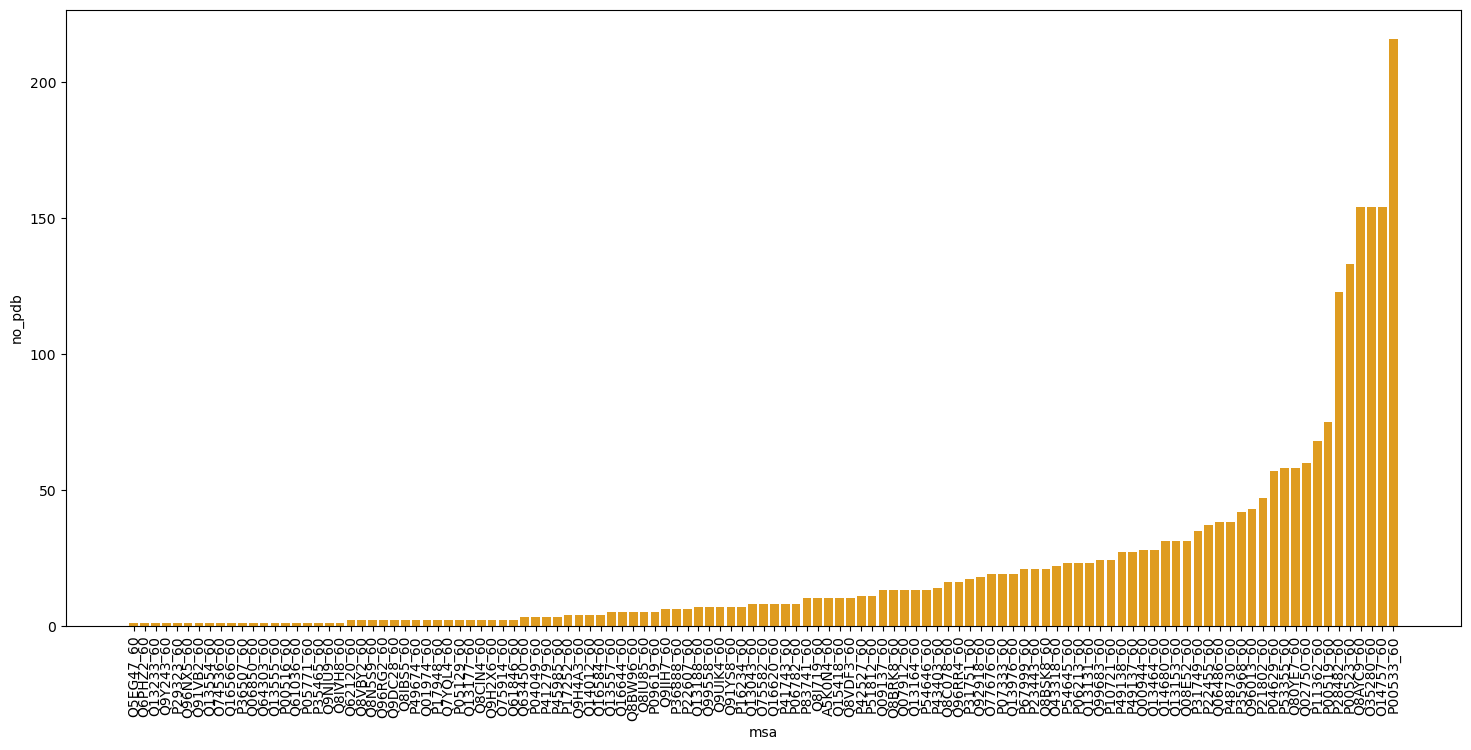

In [78]:
msa_pdb_distrib_60 = msa_pdb_distrib[msa_pdb_distrib.msa.str.endswith("_60")].sort_values("no_pdb")
plt.figure(figsize= (18,8))
sns.barplot(data= msa_pdb_distrib_60, x= 'msa', y= 'no_pdb', color= 'orange')
plt.xticks(rotation= 90)
plt.plot()

<AxesSubplot:>

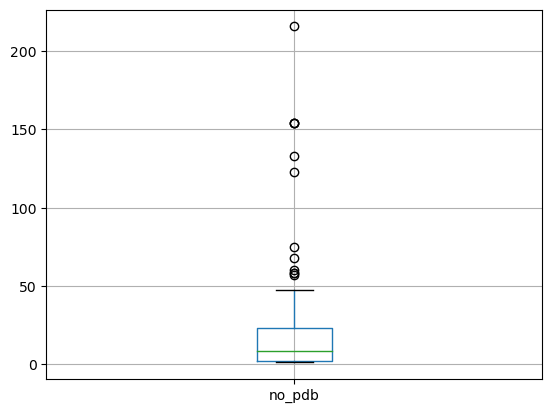

In [79]:
msa_pdb_distrib_60.boxplot()

---

In [80]:
# ortho_uniprot = pd.read_csv('../raw_data/orthologs-uniprot-structure-2022.11.18-20.00.24.25.tsv.gz', sep= '\t', compression= 'gzip')
# ortho_uniprot.info()

In [81]:
#mapping_uniprot_pdb = pd.read_csv('../raw_data/orthologs-uniprot-pdb-mapping-compressed-2022.11.22-16.55.31.52.tsv.gz', sep= '\t', compression= 'gzip')

In [82]:
#mapping_uniprot_pdb.To.nunique()

In [83]:
#mapping_uniprot_pdb.From.nunique()

In [92]:
Q8C078_60 = msa_pdb[msa_pdb.uniprot == 'Q96RR4'][['msa' ,'uniprot', 'pdb']].drop_duplicates()
Q8C078_60

,msa,uniprot,pdb
0,Q8C078_60,Q96RR4,5yv8
1,Q8C078_60,Q96RR4,5yvb
2,Q8C078_60,Q96RR4,5yvc
3,Q8C078_60,Q96RR4,5yva
4,Q8C078_60,Q96RR4,5yv9
...,...,...,...
207,Q8C078_all,Q96RR4,6ble
208,Q8C078_all,Q96RR4,6brc
209,Q8C078_all,Q96RR4,6bqp
210,Q8C078_all,Q96RR4,6bqq


In [93]:
regions[regions.Uniprot_acc == 'Q96RR4']

,Uniprot_acc,Start,End,Term_id
244,Q96RR4,165,446,kd245
530,Q96RR4,471,499,cre245


In [95]:
sift[sift.sp_primary == 'Q96RR4']

,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
155554,5yv8,A,Q96RR4,10,49,160,199,160,199
155555,5yv8,A,Q96RR4,79,298,229,448,229,448
155558,5yvb,A,Q96RR4,10,49,160,199,160,199
155559,5yvb,A,Q96RR4,79,298,229,448,229,448
156457,6ble,A,Q96RR4,3,46,161,204,161,204
156458,6ble,A,Q96RR4,72,290,230,448,230,448
243085,6y8a,P,Q96RR4,1,7,508,514,508,514
281875,5yvc,A,Q96RR4,10,49,160,199,160,199
281876,5yvc,A,Q96RR4,79,298,229,448,229,448
282695,6bku,A,Q96RR4,4,48,162,206,162,206
